<a href="https://colab.research.google.com/github/Ignacioelamo/LLMs4Phishing/blob/main/repharsing_data_generation_Gemini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importación librerías

In [ ]:
# Sistema
import sys
import time
import getpass
import string

# Hugging Face
from huggingface_hub import login
from transformers import (
    pipeline,
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig
)

# PyTorch
import torch

# Progreso
from tqdm import tqdm
from tqdm.notebook import tqdm as notebook_tqdm

# DataFrames
import pandas as pd

# Serialización
import pickle
import joblib

# NLP - NLTK y spaCy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import spacy

# Sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score

import seaborn as sns
import matplotlib.pyplot as plt


# warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")


Instalamos las librerías necesarias

In [ ]:
!pip install bitsandbytes

# Preparación del Entorno

In [ ]:
repo_url = "https://github.com/Ignacioelamo/LLMs4Phishing"
!git clone {repo_url}
!cd LLMs4Phishing

fatal: destination path 'LLMs4Phishing' already exists and is not an empty directory.


In [ ]:
# Añadir los directorio fuentes al path de Python
sys.path.append('/content/LLMs4Phishing/src')

# Verificar que se han añadido correctamente
print(sys.path)

from rephrasers import EmailRephraser
from utils import preprocess_texts

['/content', '/env/python', '/usr/lib/python311.zip', '/usr/lib/python3.11', '/usr/lib/python3.11/lib-dynload', '', '/usr/local/lib/python3.11/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.11/dist-packages/IPython/extensions', '/root/.ipython', '/usr/local/lib/python3.11/dist-packages/setuptools/_vendor', '/tmp/tmpf2we21gp', '/content/LLMs4Phishing/src']


# Pruebas

## Resultados pruebas modelo Belen

In [ ]:
#Cargamos el modelo de scikit-learn
with open('./LLMs4Phishing/models/tfidf_vectorizer.pkl', 'rb') as f:
    vectorizer = pickle.load(f)

model_baseline = joblib.load('./LLMs4Phishing/models/svm.joblib')

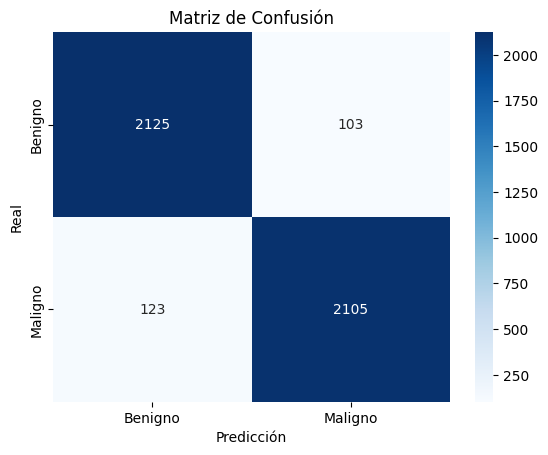

In [ ]:
#Cargamos el dataset test
test_df = pd.read_csv('./LLMs4Phishing/data/test_data.csv')

# Vectorizar el texto de test_df
X_test = vectorizer.transform(test_df['clean_text'])  # Transformar el test con el mismo vectorizador
# Predecir las etiquetas
y_test = test_df['label']
y_pred = model_baseline.predict(X_test)

# Añadir las predicciones al DataFrame
test_df['predicted_label'] = y_pred


cm = confusion_matrix(y_test, y_pred)


# Visualización con Seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benigno', 'Maligno'], yticklabels=['Benigno', 'Maligno'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

Vamos a conservar únicamente las predicciones clasificadas como negativas que efectivamente son negativas, con el objetivo de aplicar técnicas de rephrasing sobre ellas.

In [ ]:
#Guarda en un csv los que son negativos y han sido detectados como negativos, al final lo que buscamos es ver el poder del rephrasing para transformar un email original maligno a uno benigno
true_positives = test_df[(test_df['label'] == 1) & (test_df['predicted_label'] == 1)]
true_positives.to_csv('true_positives.csv', index=False)

## Cargamos el modelo Llama

In [ ]:
rephraser = EmailRephraser()

Hacemos el rephrasing y lo guardamos en zero_shot_dataset_true_positives.csv

In [ ]:
dataset_path = "./true_positives.csv"

#Leeme el dataset sin la columna index
df = pd.read_csv(dataset_path)


# Procesar el dataset con tqdm para mostrar progreso
new_subjects = []
new_bodies = []

#print("Procesando el dataset...")
start_time = time.time()

for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Filas procesadas"):
    new_subject, new_body = rephraser.generate_rephrased_text(row["subject"], row["body"])
    new_subjects.append(new_subject)
    new_bodies.append(new_body)

end_time = time.time()
#print(f"Tiempo total de inferencia: {end_time - start_time:.2f} segundos")

# Crear nuevo DataFrame con los resultados, manteniendo sender y receiver originales
df_new = pd.DataFrame({
    "subject": new_subjects,
    "sender": df["sender"],  # Mantener el original
    "receiver": df["receiver"],  # Mantener el original
    "body": new_bodies
})

# Guardar el nuevo dataset en un CSV
df_new.to_csv("zero_shot_dataset_true_positives.csv", index=False)
print("Nuevo dataset guardado como 'zero_shot_dataset_true_positives.csv'")


Lo limpiamos como hizo Belén originalmente

In [ ]:
df_new = pd.read_csv("zero_shot_dataset_true_positives.csv")
df_new['clean_text'] = preprocess_texts(df_new['body'])

In [ ]:
# Cargar el test_df
test_df = df_new.copy()

# Transformar el test con el mismo vectorizador
X_test = vectorizer.transform(test_df['clean_text'])

y_test = [1] * len(test_df)
y_pred = model_baseline.predict(X_test)


recall = recall_score(y_test, y_pred)
print(f"Recall (Sensibilidad): {recall:.4f}")

Recall (Sensibilidad): 0.9772
